# Bayesian linear regression

[Source](https://twiecki.github.io/)

In [1]:
%matplotlib inline

from pymc3 import  *

import numpy as np
import matplotlib.pyplot as plt

In [2]:
size = 200
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + np.random.normal(scale=.5, size=size)

data = dict(x=x, y=y)

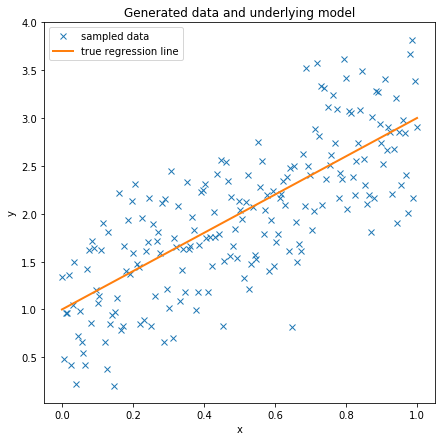

In [3]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data and underlying model')
ax.plot(x, y, 'x', label='sampled data')
ax.plot(x, true_regression_line, label='true regression line', lw=2.)
plt.legend(loc=0);

In [4]:
with Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    sigma = HalfCauchy('sigma', beta=10, testval=1.)
    intercept = Normal('Intercept', 0, sd=20)
    x_coeff = Normal('x', 0, sd=20)
    
    # Define likelihood
    likelihood = Normal('y', mu=intercept + x_coeff * x, 
                        sd=sigma, observed=y)
    
    # Inference!
    trace = sample(progressbar=False) # draw posterior samples using NUTS sampling

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x, Intercept, sigma]
C:\Users\anubhav.dhiman\AppData\Local\Continuum\anaconda3\envs\dev-py36\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


<Figure size 504x504 with 0 Axes>

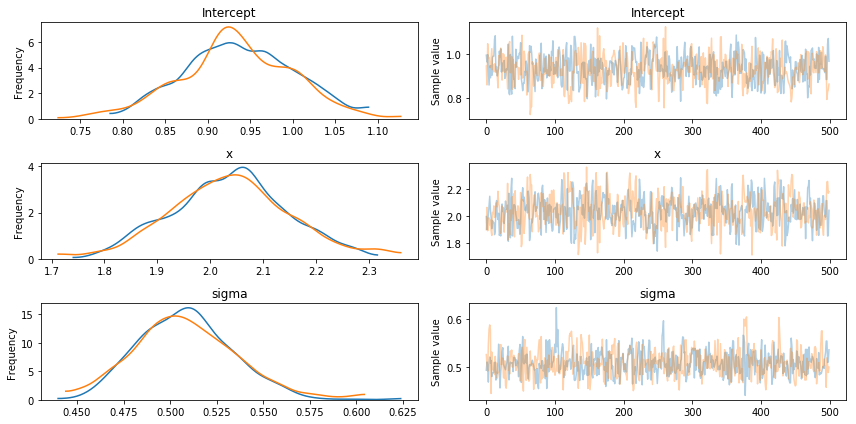

In [5]:
plt.figure(figsize=(7, 7))
traceplot(trace)
plt.tight_layout();

In [6]:
with Model() as model:
    # specify glm and pass in data. The resulting linear model, its likelihood and 
    # and all its parameters are automatically added to our model.
    GLM.from_formula('y ~ x', data)
    trace = sample(progressbar=False, tune=1000, njobs=4) # draw posterior samples using NUTS sampling

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, x, Intercept]
C:\Users\anubhav.dhiman\AppData\Local\Continuum\anaconda3\envs\dev-py36\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
The acceptance probability does not match the target. It is 0.8863284262061756, but should be close to 0.8. Try to increase the number of tuning steps.


<Figure size 504x504 with 0 Axes>

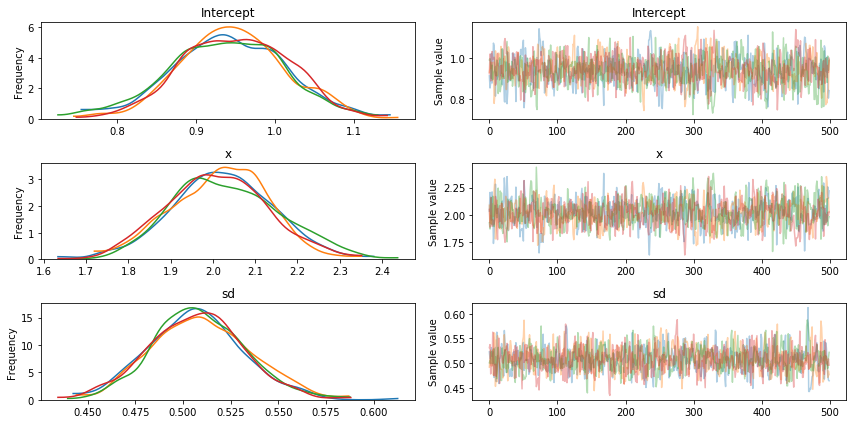

In [7]:
plt.figure(figsize=(7, 7))
traceplot(trace)
plt.tight_layout();

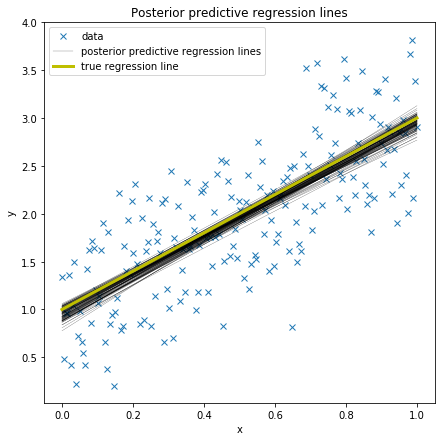

In [8]:
plt.figure(figsize=(7, 7))
plt.plot(x, y, 'x', label='data')
plots.plot_posterior_predictive_glm(trace, samples=100, 
                                    label='posterior predictive regression lines')
plt.plot(x, true_regression_line, label='true regression line', lw=3., c='y')

plt.title('Posterior predictive regression lines')
plt.legend(loc=0)
plt.xlabel('x')
plt.ylabel('y');

# Robust regression
Replacing the normal likelihood with Student T distribution produces robust regression.

In [9]:
%matplotlib inline

import pymc3 as pm

import matplotlib.pyplot as plt
import numpy as np

import theano

In [10]:
size = 100
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + np.random.normal(scale=.5, size=size)

# Add outliers
x_out = np.append(x, [.1, .15, .2])
y_out = np.append(y, [8, 6, 9])

data = dict(x=x_out, y=y_out)

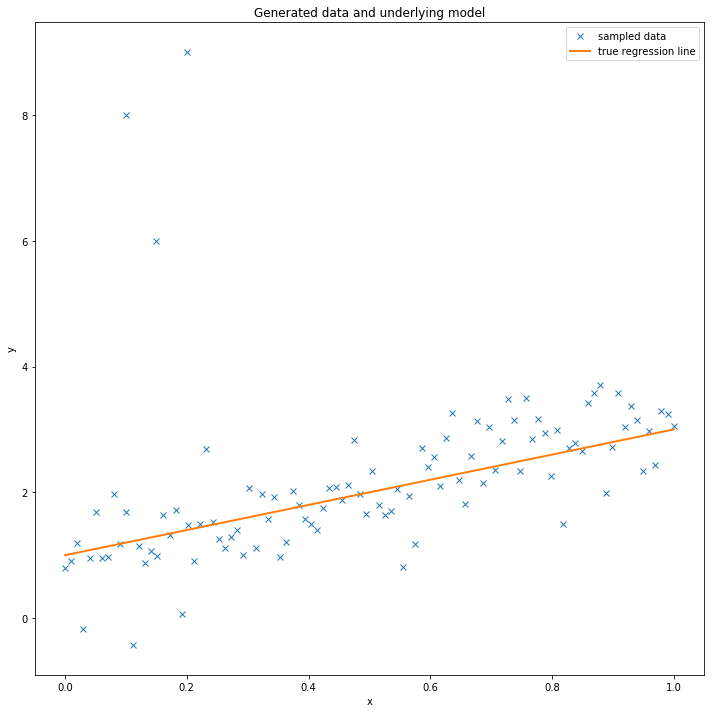

In [11]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data and underlying model')
ax.plot(x_out, y_out, 'x', label='sampled data')
ax.plot(x, true_regression_line, label='true regression line', lw=2.)
plt.legend(loc=0);

In [12]:
with pm.Model() as model:
    pm.GLM.from_formula('y ~ x', data)
    trace = pm.sample(progressbar=False, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, x, Intercept]
C:\Users\anubhav.dhiman\AppData\Local\Continuum\anaconda3\envs\dev-py36\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
The acceptance probability does not match the target. It is 0.8849432350377882, but should be close to 0.8. Try to increase the number of tuning steps.


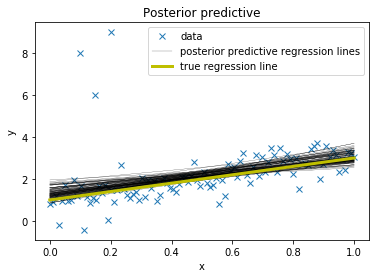

In [13]:
plt.subplot(111, xlabel='x', ylabel='y', 
            title='Posterior predictive regression lines')
plt.plot(x_out, y_out, 'x', label='data')
pm.plots.plot_posterior_predictive_glm(trace, samples=100, 
                                 label='posterior predictive regression lines')
plt.plot(x, true_regression_line, 
         label='true regression line', lw=3., c='y')

plt.legend(loc=0);

The fit is quite skewed and we have a fair amount of uncertainty in our estimate as indicated by the wide range of different posterior predictive regression lines. Why is this? The reason is that the normal distribution does not have a lot of mass in the tails and consequently, an outlier will affect the fit strongly.

Since the problem is the light tails of the Normal distribution we can instead assume that our data is not normally distributed but instead distributed according to the Student T distribution which has heavier tails

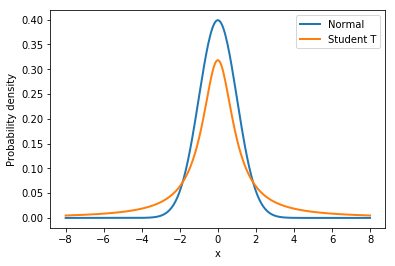

In [14]:
normal_dist = pm.Normal.dist(mu=0, sd=1)
t_dist = pm.StudentT.dist(mu=0, lam=1, nu=1)
x_eval = np.linspace(-8, 8, 300)
plt.plot(x_eval, theano.tensor.exp(normal_dist.logp(x_eval)).eval(), label='Normal', lw=2.)
plt.plot(x_eval, theano.tensor.exp(t_dist.logp(x_eval)).eval(), label='Student T', lw=2.)
plt.xlabel('x')
plt.ylabel('Probability density')
plt.legend();

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lam, x, Intercept]
C:\Users\anubhav.dhiman\AppData\Local\Continuum\anaconda3\envs\dev-py36\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


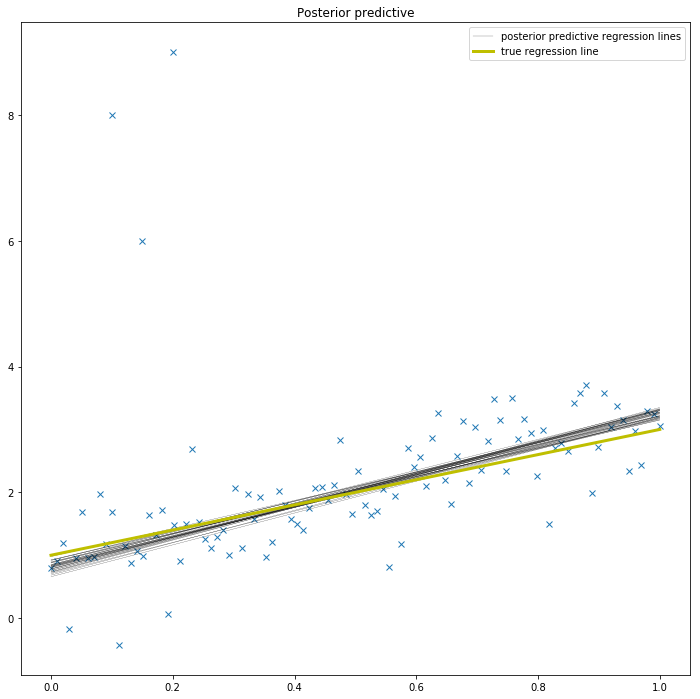

In [15]:
with pm.Model() as model_robust:
    family = pm.glm.families.StudentT()
    pm.GLM.from_formula('y ~ x', data, family=family)
    trace_robust = pm.sample(progressbar=False, tune=1000)

plt.figure(figsize=(12, 12))
plt.plot(x_out, y_out, 'x')
pm.plots.plot_posterior_predictive_glm(trace_robust,
                                       label='posterior predictive regression lines')
plt.plot(x, true_regression_line, 
         label='true regression line', lw=3., c='y')
plt.legend();

There, much better! The outliers are barely influencing our estimation at all because our likelihood function assumes that outliers are much more probable than under the Normal distribution.

# Hierarchical Linear Regression 

In [16]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm 
import pandas as pd

data = pd.read_csv('data/radon.csv')

county_names = data.county.unique()
county_idx = data['county_code'].values

In [17]:
data[['county', 'log_radon', 'floor']].head()

,county,log_radon,floor
0,AITKIN,0.832909,1.0
1,AITKIN,0.832909,0.0
2,AITKIN,1.098612,0.0
3,AITKIN,0.095310,0.0
4,ANOKA,1.163151,0.0


## Individual/non-hierarchical model

In [18]:
%%time
# takes about 45 minutes
indiv_traces = {}
for county_name in county_names:
    # Select subset of data belonging to county
    c_data = data.ix[data.county == county_name]
    c_data = c_data.reset_index(drop=True)
    
    c_log_radon = c_data.log_radon
    c_floor_measure = c_data.floor.values
    
    with pm.Model() as individual_model:
        # Intercept prior
        a = pm.Normal('alpha', mu=0, sd=1)
        # Slope prior
        b = pm.Normal('beta', mu=0, sd=1)
    
        # Model error prior
        eps = pm.HalfCauchy('eps', beta=1)
    
        # Linear model
        radon_est = a + b * c_floor_measure
    
        # Data likelihood
        y_like = pm.Normal('y_like', mu=radon_est, sd=eps, observed=c_log_radon)

        # Inference button (TM)!
        trace = pm.sample(progressbar=False)
        
    indiv_traces[county_name] = trace

C:\Users\anubhav.dhiman\AppData\Local\Continuum\anaconda3\envs\dev-py36\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, beta, alpha]
C:\Users\anubhav.dhiman\AppData\Local\Continuum\anaconda3\envs\dev-py36\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
C:\Users\anubhav.dhiman\AppData\Local\Continuum\anaconda3\envs\dev-py36\lib\

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, beta, alpha]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, beta, alpha]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, beta, alpha]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, beta, alpha]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, beta, alpha]
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, beta, alpha]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, beta, alpha]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, beta, alpha]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, beta, alpha]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, beta, alpha]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, beta, alpha]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, beta, alpha]
Auto-assigning NUTS sam

Wall time: 54min 9s


## Hierarchical Model

In [19]:
with pm.Model() as hierarchical_model:
    # Hyperpriors
    mu_a = pm.Normal('mu_alpha', mu=0., sd=1)
    sigma_a = pm.HalfCauchy('sigma_alpha', beta=1)
    mu_b = pm.Normal('mu_beta', mu=0., sd=1)
    sigma_b = pm.HalfCauchy('sigma_beta', beta=1)
    
    # Intercept for each county, distributed around group mean mu_a
    a = pm.Normal('alpha', mu=mu_a, sd=sigma_a, shape=len(data.county.unique()))
    # Intercept for each county, distributed around group mean mu_a
    b = pm.Normal('beta', mu=mu_b, sd=sigma_b, shape=len(data.county.unique()))
    
    # Model error
    eps = pm.HalfCauchy('eps', beta=1)
    
    # Expected value
    radon_est = a[county_idx] + b[county_idx] * data.floor.values
    
    # Data likelihood
    y_like = pm.Normal('y_like', mu=radon_est, sd=eps, observed=data.log_radon)

Wall time: 3.6 s


In [20]:
%%time
with hierarchical_model:
    hierarchical_trace = pm.sample(njobs=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, beta, alpha, sigma_beta, mu_beta, sigma_alpha, mu_alpha]
Sampling 4 chains: 100%|███████████████████████████████████████████████████████| 4000/4000 [00:18<00:00, 218.59draws/s]
C:\Users\anubhav.dhiman\AppData\Local\Continuum\anaconda3\envs\dev-py36\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
The acceptance probability does not match the target. It is 0.8853791863412983, but should be close to 0.8. Try to increase the number of tuning steps.
There were 104 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probabi

Wall time: 1min 11s


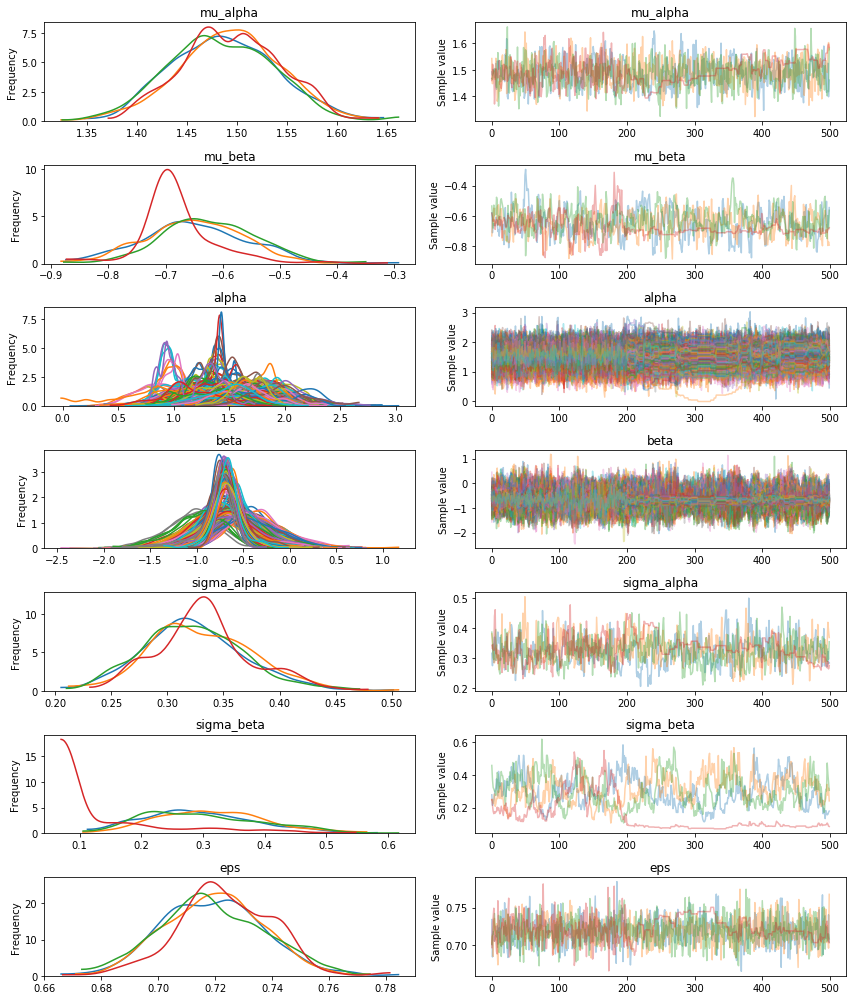

In [21]:
pm.traceplot(hierarchical_trace);

The marginal posteriors in the left column are highly informative. mu_a tells us the group mean (log) radon levels. mu_b tells us that having no basement decreases radon levels significantly (no mass above zero). We can also see by looking at the marginals for a that there is quite some differences in radon levels between counties

## Posterior Predictive Check

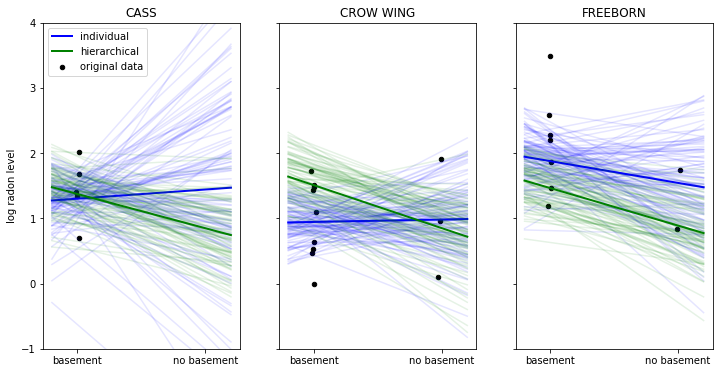

In [24]:
selection = ['CASS', 'CROW WING', 'FREEBORN']
fig, axis = plt.subplots(1, 3, figsize=(12, 6), sharey=True, sharex=True)
axis = axis.ravel()
for i, c in enumerate(selection):
    c_data = data.loc[data.county == c]
    c_data = c_data.reset_index(drop = True)
    z = list(c_data['county_code'])[0]

    xvals = np.linspace(-0.2, 1.2)
    for a_val, b_val in zip(indiv_traces[c]['alpha'][::10], indiv_traces[c]['beta'][::10]):
        axis[i].plot(xvals, a_val + b_val * xvals, 'b', alpha=.1)
    axis[i].plot(xvals, indiv_traces[c]['alpha'][::10].mean() + indiv_traces[c]['beta'][::10].mean() * xvals, 
                 'b', alpha=1, lw=2., label='individual')
    for a_val, b_val in zip(hierarchical_trace['alpha'][::10][z], hierarchical_trace['beta'][::10][z]):
        axis[i].plot(xvals, a_val + b_val * xvals, 'g', alpha=.1)
    axis[i].plot(xvals, hierarchical_trace['alpha'][::10][z].mean() + hierarchical_trace['beta'][::10][z].mean() * xvals, 
                 'g', alpha=1, lw=2., label='hierarchical')
    axis[i].scatter(c_data.floor + np.random.randn(len(c_data))*0.01, c_data.log_radon, 
                    alpha=1, color='k', marker='.', s=80, label='original data')
    axis[i].set_xticks([0,1])
    axis[i].set_xticklabels(['basement', 'no basement'])
    axis[i].set_ylim(-1, 4)
    axis[i].set_title(c)
    if not i%3:
        axis[i].legend()
        axis[i].set_ylabel('log radon level')

When looking at the county 'CASS' we see that the non-hierarchical estimation is strongly biased: as this county's data contains only households with a basement the estimated regression produces the non-sensical result of a giant negative slope meaning that we would expect negative radon levels in a house without basement!

Moreover, in the example county's 'CROW WING' and 'FREEBORN' the non-hierarchical model appears to react more strongly than the hierarchical model to the existance of outliers in the dataset.

## Shrinkage

Shrinkage describes the process by which our estimates are "pulled" towards the group-mean as a result of the common group distribution -- county-coefficients very far away from the group mean have very low probability under the normality assumption. In the non-hierachical model every county is allowed to differ completely from the others by just using each county's data, resulting in a model more prone to outliers

In [25]:
hier_a = hierarchical_trace['alpha'].mean(axis=0)
hier_b = hierarchical_trace['beta'].mean(axis=0)
indv_a = [indiv_traces[c]['alpha'].mean() for c in county_names]
indv_b = [indiv_traces[c]['beta'].mean() for c in county_names]

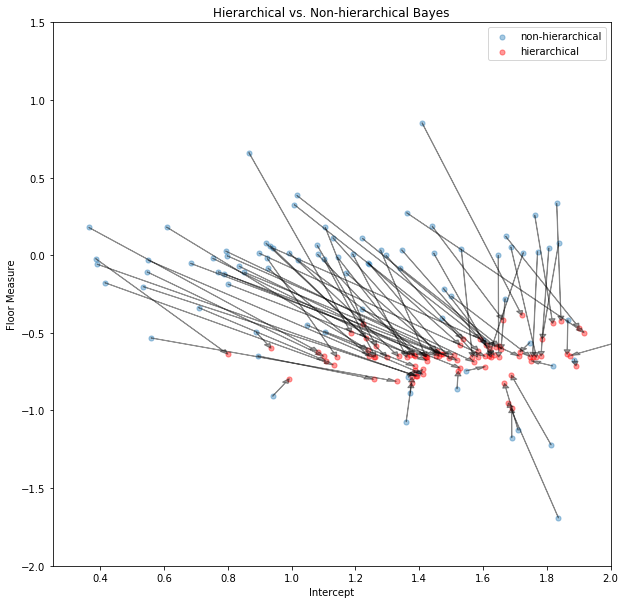

In [26]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, xlabel='Intercept', ylabel='Floor Measure', 
                     title='Hierarchical vs. Non-hierarchical Bayes', 
                     xlim=(0.25, 2), ylim=(-2, 1.5))

ax.scatter(indv_a,indv_b, s=26, alpha=0.4, label = 'non-hierarchical')
ax.scatter(hier_a,hier_b, c='red', s=26, alpha=0.4, label = 'hierarchical')
for i in range(len(indv_b)):  
    ax.arrow(indv_a[i], indv_b[i], hier_a[i] - indv_a[i], hier_b[i] - indv_b[i], 
             fc="k", ec="k", length_includes_head=True, alpha=0.4, head_width=.02)
ax.legend();

Interestingly, all hierarchical posteriors of the floor-measure seem to be around -0.6 indicating that having a basement in almost all county's is a clear indicator for heightend radon levels. The intercept (which we take for type of soil) appears to differ among county's. This information would have been difficult to find when just the non-hierarchial model had been used.

# The intuitive specification
Usually, hierachical models are specified in a centered way. In a regression model, individual slopes would be centered around a group mean with a certain group variance, which controls the shrinkage:

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm 
import pandas as pd
import theano
import seaborn as sns

sns.set_style('whitegrid')
np.random.seed(123)

data = pd.read_csv('data/radon.csv')
data['log_radon'] = data['log_radon'].astype(theano.config.floatX)
county_names = data.county.unique()
county_idx = data.county_code.values

n_counties = len(data.county.unique())

In [29]:
with pm.Model() as hierarchical_model_centered:
    # Hyperpriors for group nodes
    mu_a = pm.Normal('mu_a', mu=0., sd=100**2)
    sigma_a = pm.HalfCauchy('sigma_a', 5)
    mu_b = pm.Normal('mu_b', mu=0., sd=100**2)
    sigma_b = pm.HalfCauchy('sigma_b', 5)

    # Intercept for each county, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_counties).
    a = pm.Normal('a', mu=mu_a, sd=sigma_a, shape=n_counties)

    # Intercept for each county, distributed around group mean mu_a
    b = pm.Normal('b', mu=mu_b, sd=sigma_b, shape=n_counties)

    # Model error
    eps = pm.HalfCauchy('eps', 5)
    
    # Linear regression
    radon_est = a[county_idx] + b[county_idx] * data.floor.values
    
    # Data likelihood
    radon_like = pm.Normal('radon_like', mu=radon_est, sd=eps, observed=data.log_radon)

In [30]:
# Inference button (TM)!
with hierarchical_model_centered:
    hierarchical_centered_trace = pm.sample(draws=5000, tune=1000, njobs=4)[1000:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]
Sampling 4 chains: 100%|█████████████████████████████████████████████████████| 24000/24000 [01:43<00:00, 231.50draws/s]
C:\Users\anubhav.dhiman\AppData\Local\Continuum\anaconda3\envs\dev-py36\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
There were 238 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6498001792193694, but should be close to 0.8. Try to increase the number of tuning steps.
There were 14 divergences after tuning. Inc

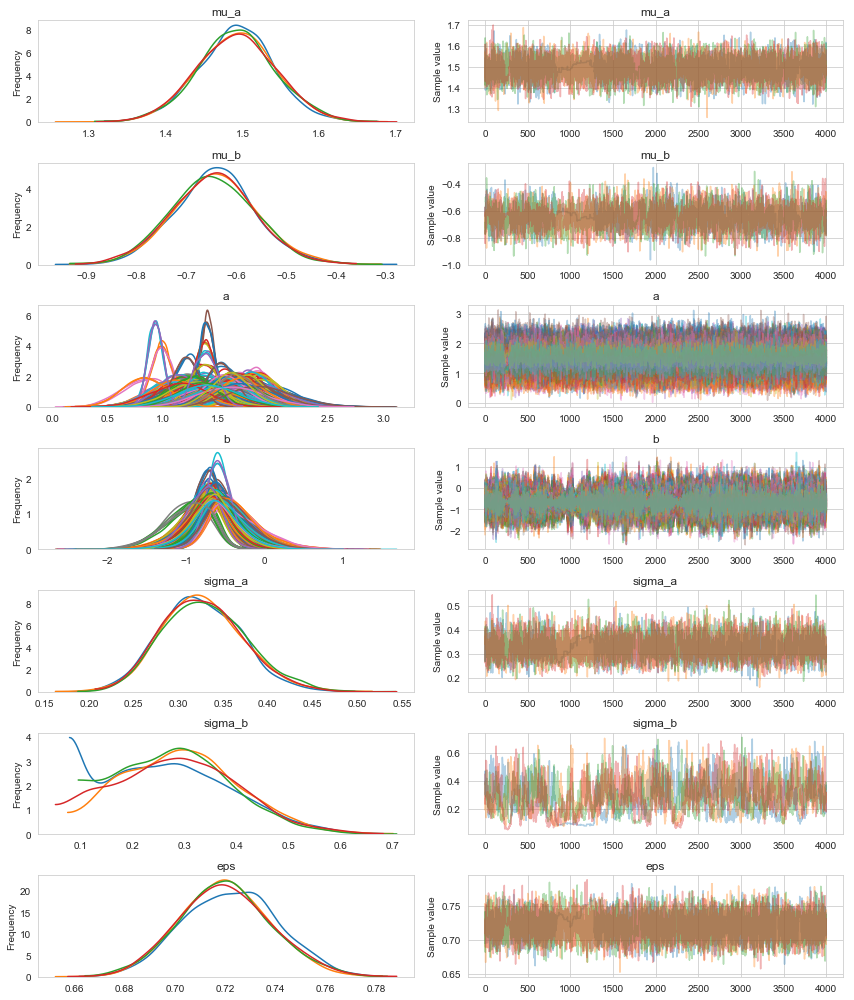

In [31]:
pm.traceplot(hierarchical_centered_trace);

Perhaps sigma_b has some problems

In [32]:
print('Rhat(sigma_b) = {}'.format(pm.diagnostics.gelman_rubin(hierarchical_centered_trace)['sigma_b']))

Rhat(sigma_b) = 1.0041907497721485


let's take a closer look at the slopes b and their group variance (i.e. how far they are allowed to move from the mean) sigma_b. I'm just plotting a single chain now.

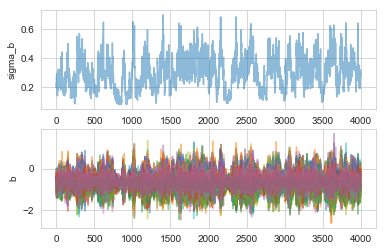

In [33]:
fig, axs = plt.subplots(nrows=2)
axs[0].plot(hierarchical_centered_trace.get_values('sigma_b', chains=1), alpha=.5);
axs[0].set(ylabel='sigma_b');
axs[1].plot(hierarchical_centered_trace.get_values('b', chains=1), alpha=.5);
axs[1].set(ylabel='b');

Let's look at the joint posterior of a single slope b (I randomly chose the 75th one) and the slope group variance sigma_b.

C:\Users\anubhav.dhiman\AppData\Local\Continuum\anaconda3\envs\dev-py36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


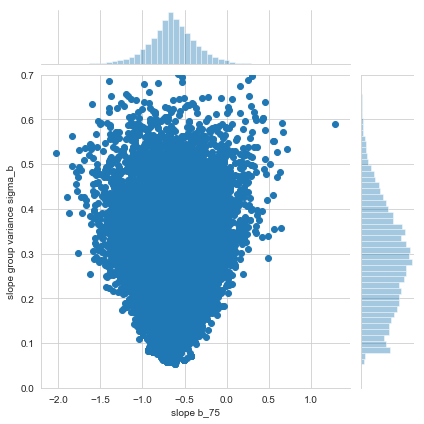

In [34]:
x = pd.Series(hierarchical_centered_trace['b'][:, 75], name='slope b_75')
y = pd.Series(hierarchical_centered_trace['sigma_b'], name='slope group variance sigma_b')

sns.jointplot(x, y, ylim=(0, .7));

This makes sense, as the slope group variance goes to zero (or, said differently, we apply maximum shrinkage), individual slopes are not allowed to deviate from the slope group mean, so they all collapose to the group mean.

While this property of the posterior in itself is not problematic, it makes the job extremely difficult for our sampler

## Reparameterization

In [35]:
with pm.Model() as hierarchical_model_non_centered:
    # Hyperpriors for group nodes
    mu_a = pm.Normal('mu_a', mu=0., sd=100**2)
    sigma_a = pm.HalfCauchy('sigma_a', 5)
    mu_b = pm.Normal('mu_b', mu=0., sd=100**2)
    sigma_b = pm.HalfCauchy('sigma_b', 5)

    # Before:
    # a = pm.Normal('a', mu=mu_a, sd=sigma_a, shape=n_counties)
    # Transformed:
    a_offset = pm.Normal('a_offset', mu=0, sd=1, shape=n_counties)
    a = pm.Deterministic("a", mu_a + a_offset * sigma_a)

    # Before:
    # b = pm.Normal('b', mu=mu_b, sd=sigma_b, shape=n_counties)
    # Now:
    b_offset = pm.Normal('b_offset', mu=0, sd=1, shape=n_counties)
    b = pm.Deterministic("b", mu_b + b_offset * sigma_b)

    # Model error
    eps = pm.HalfCauchy('eps', 5)
    
    radon_est = a[county_idx] + b[county_idx] * data.floor.values
    
    # Data likelihood
    radon_like = pm.Normal('radon_like', mu=radon_est, sd=eps, observed=data.log_radon)

Pay attention to the definitions of a_offset, a, b_offset, and b and compare them to before (commented out). What's going on here? It's pretty neat actually. Instead of saying that our individual slopes b are normally distributed around a group mean (i.e. modeling their absolute values directly), we can say that they are offset from a group mean by a certain value (b_offset; i.e. modeling their values relative to that mean). Now we still have to consider how far from that mean we actually allow things to deviate (i.e. how much shrinkage we apply). This is where sigma_b makes a comeback. We can simply multiply the offset by this scaling factor to get the same effect as before, just under a different parameterization

In [36]:
# Inference button (TM)!
with hierarchical_model_non_centered:
    hierarchical_non_centered_trace = pm.sample(draws=5000, tune=1000, njobs=4)[1000:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b_offset, a_offset, sigma_b, mu_b, sigma_a, mu_a]
Sampling 4 chains: 100%|█████████████████████████████████████████████████████| 24000/24000 [01:18<00:00, 304.80draws/s]
C:\Users\anubhav.dhiman\AppData\Local\Continuum\anaconda3\envs\dev-py36\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


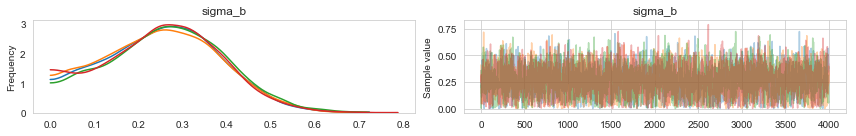

In [37]:
pm.traceplot(hierarchical_non_centered_trace, varnames=['sigma_b']);

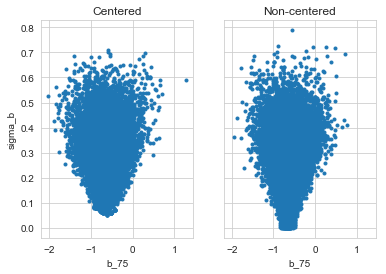

In [38]:
fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True)

x = pd.Series(hierarchical_centered_trace['b'][:, 75], name='slope b_75')
y = pd.Series(hierarchical_centered_trace['sigma_b'], name='slope group variance sigma_b')

axs[0].plot(x, y, '.');
axs[0].set(title='Centered', ylabel='sigma_b', xlabel='b_75')

x = pd.Series(hierarchical_non_centered_trace['b'][:, 75], name='slope b_75')
y = pd.Series(hierarchical_non_centered_trace['sigma_b'], name='slope group variance sigma_b')

axs[1].plot(x, y, '.');
axs[1].set(title='Non-centered', xlabel='b_75');

let's also compare the sigma_b marginal posteriors of the two models:

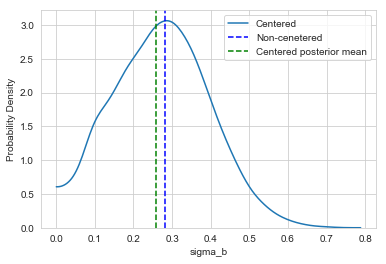

In [39]:
pm.kdeplot(np.stack([hierarchical_centered_trace['sigma_b'], hierarchical_non_centered_trace['sigma_b'], ]).T)
plt.axvline(hierarchical_centered_trace['sigma_b'].mean(), color='b', linestyle='--')
plt.axvline(hierarchical_non_centered_trace['sigma_b'].mean(), color='g', linestyle='--')
plt.legend(['Centered', 'Non-cenetered', 'Centered posterior mean', 'Non-centered posterior mean']); 
plt.xlabel('sigma_b'); plt.ylabel('Probability Density');

### Why does the reparameterized model work better?
To more clearly understand why this model works better, let's look at the joint distribution of b_offset:

C:\Users\anubhav.dhiman\AppData\Local\Continuum\anaconda3\envs\dev-py36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


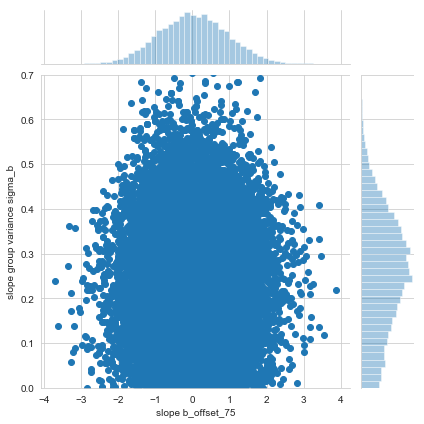

In [41]:
x = pd.Series(hierarchical_non_centered_trace['b_offset'][:, 75], name='slope b_offset_75')
y = pd.Series(hierarchical_non_centered_trace['sigma_b'], name='slope group variance sigma_b')

sns.jointplot(x, y, ylim=(0, .7));

### Why hierarchical models are Bayesian

Let's compare the posterior mode (i.e. the MAP) to the posterior mean of our hierachical linear regression model:

In [42]:
with hierarchical_model_centered:
    mode = pm.find_MAP()

logp = -3.7003e+209, ||grad|| = inf: 100%|██████████████████████████████████████████| 261/261 [00:00<00:00, 449.16it/s]


In [43]:
mode['b']

array([0.08944288, 0.08944288, 0.08944288, 0.08944288, 0.08944288,
       0.08944288, 0.08944288, 0.08944288, 0.08944288, 0.08944288,
       0.08944288, 0.08944288, 0.08944288, 0.08944288, 0.08944288,
       0.08944288, 0.08944288, 0.08944288, 0.08944288, 0.08944288,
       0.08944288, 0.08944288, 0.08944288, 0.08944288, 0.08944288,
       0.08944288, 0.08944288, 0.08944288, 0.08944288, 0.08944288,
       0.08944288, 0.08944288, 0.08944288, 0.08944288, 0.08944288,
       0.08944288, 0.08944288, 0.08944288, 0.08944288, 0.08944288,
       0.08944288, 0.08944288, 0.08944288, 0.08944288, 0.08944288,
       0.08944288, 0.08944288, 0.08944288, 0.08944288, 0.08944288,
       0.08944288, 0.08944288, 0.08944288, 0.08944288, 0.08944288,
       0.08944288, 0.08944288, 0.08944288, 0.08944288, 0.08944288,
       0.08944288, 0.08944288, 0.08944288, 0.08944288, 0.08944288,
       0.08944288, 0.08944288, 0.08944288, 0.08944288, 0.08944288,
       0.08944288, 0.08944288, 0.08944288, 0.08944288, 0.08944

In [45]:
np.exp(mode['sigma_b_log__'])

1.752120611084551e-08

In [46]:
hierarchical_non_centered_trace['b'].mean(axis=0)

array([-0.61272546, -0.77910421, -0.63826412, -0.68428699, -0.6128041 ,
       -0.6510284 , -0.43406781, -0.62466855, -0.49336905, -0.71863801,
       -0.65120043, -0.6534079 , -0.64845962, -0.71312865, -0.64680464,
       -0.64812718, -0.7699713 , -0.53736308, -0.73251122, -0.64924086,
       -0.60614324, -0.66580318, -0.63193084, -0.63842527, -0.44695734,
       -0.72765077, -0.59781318, -0.63678043, -0.65245254, -0.65396706,
       -0.65157652, -0.65124087, -0.64929862, -0.67617246, -0.61328774,
       -0.49489541, -0.62851373, -0.5844645 , -0.58897413, -0.64425838,
       -0.54779245, -0.64844341, -0.9719648 , -0.79724314, -0.75723115,
       -0.65118586, -0.80680199, -0.58605681, -0.81724679, -0.65309614,
       -0.6489761 , -0.6508143 , -0.68025686, -0.82210796, -0.57477182,
       -0.76974643, -0.67434895, -0.5905133 , -0.70966135, -0.64674504,
       -0.44296312, -0.39813426, -0.53539006, -0.67462567, -0.65262581,
       -0.60666835, -0.4261237 , -0.64771178, -0.64752755, -0.59

In [47]:
hierarchical_non_centered_trace['sigma_b'].mean(axis=0)

0.25810806149602716